In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datasets import get_dataset_config_names

In [3]:
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations.")

XTREME has 183 configurations.


In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
from datasets import load_dataset

In [6]:
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
from collections import defaultdict
from datasets import DatasetDict

In [8]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac*ds[split].num_rows)))
        )

In [9]:
import pandas as pd

In [10]:
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [11]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [12]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [13]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [14]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [15]:
panx_de = panx_ch["de"].map(create_tag_names)

In [16]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [17]:
from collections import Counter

In [18]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [19]:
from transformers import AutoTokenizer

In [20]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [21]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(bert_tokens)
print(xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [22]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

In [23]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [24]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [25]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [26]:
from transformers import AutoConfig

In [27]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

In [28]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [31]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [32]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,O,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O


In [33]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])


In [34]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [35]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [36]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [37]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [38]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [39]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=["langs", "ner_tags", "tokens"])

In [40]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [41]:
from seqeval.metrics import classification_report

In [42]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [43]:
import numpy as np

In [44]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [45]:
from transformers import TrainingArguments

In [46]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned_panx-de"
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    report_to="none"
)

In [47]:
from huggingface_hub import notebook_login

notebook_login()

In [48]:
from seqeval.metrics import f1_score

In [49]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)

    return {"f1": f1_score(y_true, y_pred)}

In [50]:
from transformers import DataCollatorForTokenClassification

In [51]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [52]:
def model_init():
    return XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

In [53]:
from transformers import Trainer

In [54]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer
)

In [55]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.253900,0.150540,0.824563
2,0.126800,0.137969,0.850265
3,0.079400,0.136314,0.865804


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/reynaldhavard/xlm-roberta-base-finetuned_panx-de/commit/2ce4dfe0bb3ec5855664eb57b38d5651f31a7047', commit_message='Training completed!', commit_description='', oid='2ce4dfe0bb3ec5855664eb57b38d5651f31a7047', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [57]:
from torch.nn.functional import cross_entropy

In [58]:
def forward_pass_with_label(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss": loss, "predicted_label": predicted_label}

In [59]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [60]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.013388608, 0.0, 0.01115031, 0.00829453...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [61]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.52,B-LOC,▁Luz
1,10,1,I-ORG,2.72,I-LOC,▁a


In [62]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁(,▁und,▁),▁'',▁die
count,6066,989,1388,808,163,246,1171,246,2898,860
mean,0.03,0.14,0.09,0.14,0.64,0.32,0.07,0.31,0.03,0.06
sum,205.19,136.77,127.08,113.73,103.89,79.13,76.95,76.39,75.53,53.74


In [63]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.62,0.6,0.52,0.32,0.26,0.18,0.03
sum,909.35,1600.7,1989.73,1012.79,756.77,758.01,1347.36


In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [65]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

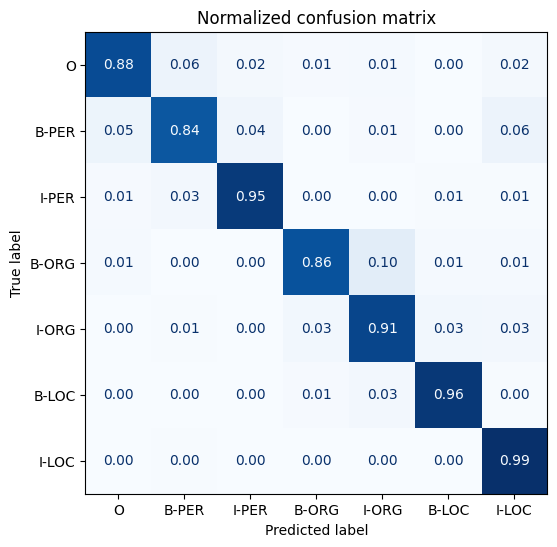

In [66]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

In [67]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T
        yield df_tmp

In [68]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,5.78,0.00,0.00,0.00,10.44,10.45,9.96,9.71,10.32,0.00,9.86,10.26,0.00,10.03,10.21,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.07,0.00,0.00,8.97,9.15,9.48,6.94,0.00,7.85,9.48,7.72,7.53,5.88,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.99,6.24,6.07,0.00,6.03,0.00,5.76,0.00,5.81,5.64,5.80,6.07,6.15,6.09,0.00


In [69]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


In [70]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [71]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.866


In [72]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [73]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])

    return get_f1_score(trainer, panx_ds["test"])

In [74]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.702


In [75]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.688


In [76]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.688


In [77]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [78]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [79]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.611400,1.290540,0.023221
2,1.186100,0.994059,0.194721
3,0.996400,0.918272,0.258691


,num_samples,f1_score
0,250,0.260191


In [80]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([
        metrics_df,
        train_on_subset(panx_fr_encoded, num_samples)],
        ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,1.424700,1.023299,0.273481
2,0.868600,0.658805,0.558438
3,0.594300,0.569413,0.631595


Epoch,Training Loss,Validation Loss,F1
1,1.070700,0.547355,0.668593
2,0.452200,0.419030,0.719858
3,0.301100,0.392787,0.765788


Epoch,Training Loss,Validation Loss,F1
1,0.774600,0.424113,0.729323
2,0.321700,0.343038,0.776030
3,0.204100,0.331930,0.813378


Epoch,Training Loss,Validation Loss,F1
1,0.587900,0.336302,0.785022
2,0.274500,0.305499,0.821070
3,0.178800,0.284760,0.833779


In [81]:
metrics_df

,num_samples,f1_score
0,250,0.260191
1,500,0.638910
2,1000,0.766782
3,2000,0.818428
4,4000,0.835797


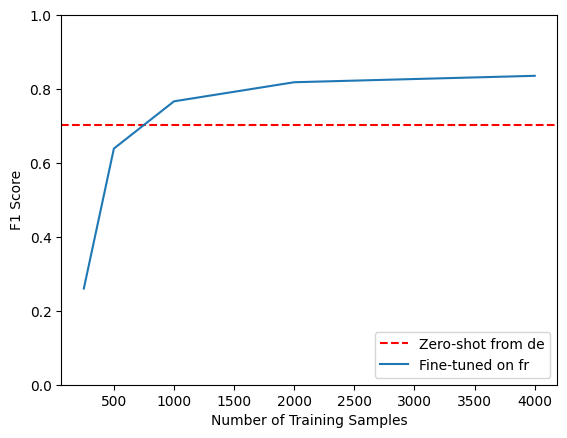

In [82]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [83]:
from datasets import concatenate_datasets

In [84]:
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [85]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [86]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.283600,0.185854,0.821246
2,0.148400,0.163191,0.848699
3,0.095300,0.163861,0.859062


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reynaldhavard/xlm-roberta-base-finetuned-panx-de-fr/commit/6a028fb87a9c193df019a21436efd859c078afbe', commit_message='Training completed!', commit_description='', oid='6a028fb87a9c193df019a21436efd859c078afbe', pr_url=None, pr_revision=None, pr_num=None)

In [87]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de] dataset: 0.865


F1-score of [de-fr] model on [fr] dataset: 0.859


F1-score of [de-fr] model on [it] dataset: 0.799


F1-score of [de-fr] model on [en] dataset: 0.674


In [88]:
corpora = [panx_de_encoded]

for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    f1_scores[lang][lang] = metrics["f1_score"][0]
    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.564700,0.324170,0.772765
2,0.267100,0.267203,0.820195
3,0.174400,0.274962,0.849510


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.721700,0.319269,0.734277
2,0.273600,0.276007,0.805522
3,0.183800,0.261933,0.832099


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,1.047900,0.485380,0.585653
2,0.460400,0.399503,0.660460
3,0.379700,0.390541,0.686066


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

In [89]:
corpora_encoded = concatenate_splits(corpora)

In [90]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.299000,0.207398,0.807836
2,0.158700,0.170465,0.846132
3,0.101200,0.175783,0.855783


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reynaldhavard/xlm-roberta-base-finetuned-panx-all/commit/6f2813efb13cb96c52c333f60650cd2277a90eb9', commit_message='Training completed!', commit_description='', oid='6f2813efb13cb96c52c333f60650cd2277a90eb9', pr_url=None, pr_revision=None, pr_num=None)

In [91]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [92]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8658,0.7021,0.6877,0.5830
each,0.8658,0.8411,0.8180,0.6870
all,0.8685,0.8654,0.8669,0.7678
